Reading `.grib` file using `pygrib`
- Creating functions to explore and plot its data


In [8]:
import pygrib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def explore_grib_file(filename):
    """Comprehensive exploration of a GRIB file"""
    
    print("=" * 60)
    print(f"EXPLORING GRIB FILE: {filename}")
    print("=" * 60)
    
    # Open the file
    grbs = pygrib.open(filename)
    
    # 1. BASIC FILE INFO
    print(f"\n📊 BASIC INFO:")
    print(f"Total messages in file: {grbs.messages}")
    
    # 2. OVERVIEW OF ALL VARIABLES
    print(f"\n🌡️  CLIMATE VARIABLES OVERVIEW:")
    variables = {}
    levels = set()
    dates = set()
    
    for i, grb in enumerate(grbs):
        var_name = grb.parameterName
        level = grb.level
        date = grb.validDate
        
        if var_name not in variables:
            variables[var_name] = {
                'count': 0,
                'levels': set(),
                'dates': set(),
                'units': grb.parameterUnits,
                'first_message': i + 1
            }
        
        variables[var_name]['count'] += 1
        variables[var_name]['levels'].add(level)
        variables[var_name]['dates'].add(date)
        levels.add(level)
        dates.add(date)
    
    # Display variables summary
    for var_name, info in variables.items():
        print(f"\n  • {var_name}")
        print(f"    Units: {info['units']}")
        print(f"    Messages: {info['count']}")
        print(f"    Levels: {sorted(list(info['levels']))}")
        print(f"    Date range: {min(info['dates'])} to {max(info['dates'])}")
    
    # 3. TEMPORAL COVERAGE
    print(f"\n📅 TEMPORAL COVERAGE:")
    sorted_dates = sorted(list(dates))
    print(f"First date: {sorted_dates[0]}")
    print(f"Last date: {sorted_dates[-1]}")
    print(f"Total unique dates: {len(sorted_dates)}")
    if len(sorted_dates) > 1:
        time_diff = sorted_dates[1] - sorted_dates[0]
        print(f"Time step: {time_diff}")
    
    # 4. VERTICAL LEVELS
    print(f"\n🏔️  VERTICAL LEVELS:")
    sorted_levels = sorted(list(levels))
    print(f"Available levels: {sorted_levels}")
    
    # 5. SPATIAL COVERAGE (using first message)
    grbs.rewind()
    first_grb = grbs.message(1)
    
    print(f"\n🌍 SPATIAL COVERAGE:")
    print(f"Grid type: {first_grb.gridType}")
    
    # Get lat/lon info
    lats, lons = first_grb.latlons()
    print(f"Grid dimensions: {first_grb.values.shape}")
    print(f"Latitude range: {lats.min():.4f}° to {lats.max():.4f}°")
    print(f"Longitude range: {lons.min():.4f}° to {lons.max():.4f}°")
    
    # Calculate approximate resolution
    if lats.shape[0] > 1 and lats.shape[1] > 1:
        lat_res = abs(lats[1,0] - lats[0,0])
        lon_res = abs(lons[0,1] - lons[0,0])
        print(f"Approximate resolution: {lat_res:.4f}° lat × {lon_res:.4f}° lon")
    
    # 6. DATA QUALITY CHECK
    print(f"\n🔍 DATA QUALITY CHECK (first variable):")
    data = first_grb.values
    print(f"Data type: {data.dtype}")
    print(f"Data range: {data.min():.4f} to {data.max():.4f} {first_grb.parameterUnits}")
    print(f"Missing values: {np.isnan(data).sum()} / {data.size}")
    print(f"Fill value used: {getattr(first_grb, 'missingValue', 'None')}")
    
    grbs.close()
    
    # 7. VISUALIZATION SUGGESTIONS
    print(f"\n📈 QUICK VISUALIZATION:")
    print("To plot your data, try:")
    print(f"plot_grib_variable('{filename}', '{first_grb.parameterName}', {sorted_dates[0]})")
    
    return variables, sorted_dates, sorted_levels

def plot_grib_variable(filename, variable_name, target_date=None, level=None):
    """Plot a specific variable from the GRIB file"""
    
    grbs = pygrib.open(filename)
    
    # Find the right message
    target_grb = None
    for grb in grbs:
        if grb.parameterName == variable_name:
            if target_date is None or grb.validDate == target_date:
                if level is None or grb.level == level:
                    target_grb = grb
                    break
    
    if target_grb is None:
        print(f"Could not find {variable_name} for the specified criteria")
        grbs.close()
        return
    
    # Get data and coordinates
    data = target_grb.values
    lats, lons = target_grb.latlons()
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Handle different coordinate systems
    if lons.max() > 180:
        lons = np.where(lons > 180, lons - 360, lons)
    
    # Plot
    contour = plt.contourf(lons, lats, data, levels=20, cmap='viridis')
    plt.colorbar(contour, label=f"{variable_name} ({target_grb.parameterUnits})")
    
    plt.title(f"{variable_name}\n{target_grb.validDate} - Level: {target_grb.level}")
    plt.xlabel('Longitude (°)')
    plt.ylabel('Latitude (°)')
    plt.grid(True, alpha=0.3)
    
    # Add some geographic context
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Equator')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print some stats about this specific field
    print(f"\n📊 STATISTICS FOR {variable_name}:")
    print(f"Date: {target_grb.validDate}")
    print(f"Level: {target_grb.level}")
    print(f"Mean: {data.mean():.4f} {target_grb.parameterUnits}")
    print(f"Std: {data.std():.4f} {target_grb.parameterUnits}")
    print(f"Min: {data.min():.4f} {target_grb.parameterUnits}")
    print(f"Max: {data.max():.4f} {target_grb.parameterUnits}")
    
    grbs.close()

EXPLORING GRIB FILE: copernicus_era5land_data/azuay_era5land_abril2024.grib

📊 BASIC INFO:
Total messages in file: 1440

🌡️  CLIMATE VARIABLES OVERVIEW:

  • 2 metre temperature
    Units: K
    Messages: 720
    Levels: [0]
    Date range: 2024-03-31 00:00:00 to 2024-04-30 00:00:00

  • Total precipitation
    Units: m
    Messages: 720
    Levels: [0]
    Date range: 2024-03-31 00:00:00 to 2024-04-30 00:00:00

📅 TEMPORAL COVERAGE:
First date: 2024-03-31 00:00:00
Last date: 2024-04-30 00:00:00
Total unique dates: 31
Time step: 1 day, 0:00:00

🏔️  VERTICAL LEVELS:
Available levels: [0]

🌍 SPATIAL COVERAGE:
Grid type: regular_ll
Grid dimensions: (13, 13)
Latitude range: -3.5000° to -2.3000°
Longitude range: -79.5000° to -78.3000°
Approximate resolution: 0.1000° lat × 0.1000° lon

🔍 DATA QUALITY CHECK (first variable):
Data type: float64
Data range: 280.2356 to 297.8938 K
Missing values: 0 / 169
Fill value used: 9999

📈 QUICK VISUALIZATION:
To plot your data, try:
plot_grib_variable('cop

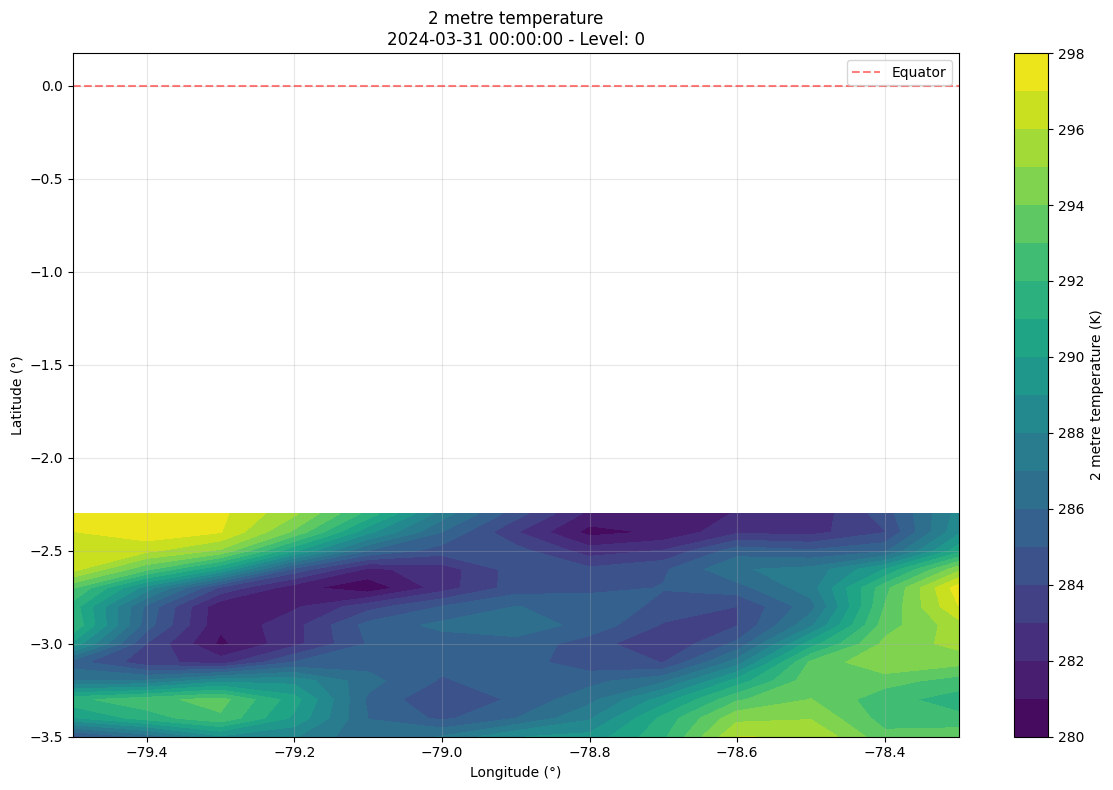


📊 STATISTICS FOR 2 metre temperature:
Date: 2024-03-31 00:00:00
Level: 0
Mean: 288.0885 K
Std: 4.6463 K
Min: 280.2356 K
Max: 297.8938 K


In [9]:
if __name__ == "__main__":
    # Replace with your GRIB file path
    grib_file = "copernicus_era5land_data/azuay_era5land_abril2024.grib"
    
    # Explore the file
    try:
        variables, dates, levels = explore_grib_file(grib_file)
        
        # Plot the first variable for the first date
        if variables and dates:
            first_var = list(variables.keys())[0]
            plot_grib_variable(grib_file, first_var, dates[0])
            
    except FileNotFoundError:
        print(f"File '{grib_file}' not found. Please update the filename.")
    except Exception as e:
        print(f"Error: {e}")
        print("Make sure pygrib is installed: pip install pygrib")